In [ ]:
import pandas as pd

#Leitura do arquivo
df_sem_alta = pd.read_pickle('../../dados_sem_alta_favoravel_desfavoravel.pickle')

# Ver as primeiras linhas do DataFrame
df_sem_alta.head()

# Ver as colunas disponíveis
df_sem_alta.columns

# Ver informações gerais (tipos, quantidade de dados, nulos, etc.)
df_sem_alta.info()

# Ver estatísticas descritivas das colunas numéricas
df_sem_alta.describe()



In [ ]:
df_sem_alta.columns

In [ ]:
df_sem_alta.info()

In [ ]:
df_sem_alta.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Cria o codificador
le_uf = LabelEncoder()

# Aplica o encoder na coluna AP_UFMUN
df_sem_alta['AP_UFMUN_NUM'] = le_uf.fit_transform(df_sem_alta['AP_UFMUN'])

# Visualiza o mapeamento original -> número
uf_mapping = dict(zip(le_uf.classes_, le_uf.transform(le_uf.classes_)))
print("Mapeamento UF -> Número:")
print(uf_mapping)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Listas de variáveis numéricas e de medicamentos usadas na análise
numerical_cols = [
    'AP_PRIPAL', 'AP_DTINIC', 'AP_DTFIM', 'AP_NUIDADE', 'AP_RACACOR',
    'AP_MOTSAI', 'AP_TRANSF', 'NUMERO_DE_TRATAMENTOS_ANTERIORES',
    'NUMERO_DE_DIAGNOSTICOS_DIFERENTES', 'TEM_CAUSAS_ASSOCIADAS',
    'TEM_CAUSAS_SECUNDARIA', 'ESTADIAMENTO_INICIO', 'ESTADIAMENTO_FIM',
    'DIF_ESTADIAMENTO', 'TOTAL_TRATAMENTOS', 'PROCEDIMENTO_INICIAL',
    'Total_Medicamentos', 'AP_UFMUN_NUM'
]

medicamentos = [
    'PACLITAXEL', 'DOXORRUBICINA', 'CICLOFOSFAMIDA', 'FLUOROURACILA',
    'METOTREXATO', 'EPIRRUBICINA', 'DOCETAXEL', 'TRASTUZUMABE', 'TAMOXIFENO',
    'CAPECITABINA', 'LETROZOL', 'ANASTROZOL', 'CARBOPLATINA', 'EXEMESTANO',
    'FULVESTRANTO', 'VINORELBINA', 'GENCITABINA', 'GOSSERELINA', 'PAMIDRONATO',
    'PERTUZUMABE', 'CISPLATINA', 'LEUPRORRELINA'
]

# Seleção das variáveis explicativas e do alvo
X = df_sem_alta[numerical_cols + medicamentos]
y = df_sem_alta['VALOR_DESFECHO']

# Cálculo da informação mútua
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# Ordenação dos resultados por relevância
mi_series = pd.Series(mi_scores, index=X.columns)
top_15 = mi_series.sort_values(ascending=False)

# Exibição das variáveis mais relevantes
print(top_15)



[codecarbon WARNING @ 10:21:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:21:16] [setup] RAM Tracking...
[codecarbon INFO @ 10:21:16] [setup] CPU Tracking...
[codecarbon WARNING @ 10:21:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 10:21:18] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz
[codecarbon WARNING @ 10:21:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:21:18] [setup] GPU Tracking...
[codecarbon INFO @ 10:21:18] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:21:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 10:21:18] >>> Tracker's 

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[codecarbon INFO @ 10:21:27] Energy consumed for RAM : 0.000024 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:21:27] Delta energy consumed for CPU with constant : 0.000428 kWh, power : 180.0 W
[codecarbon INFO @ 10:21:27] Energy consumed for All CPU : 0.000428 kWh
[codecarbon INFO @ 10:21:27] Energy consumed for all GPUs : 0.000028 kWh. Total GPU Power : 11.619798658773107 W
[codecarbon INFO @ 10:21:27] 0.000479 kWh of electricity used since the beginning.


Acurácia: 0.9512
Precisão: 0.8740
Recall: 1.0000
F1 Score: 0.9327
ROC AUC: 0.9846


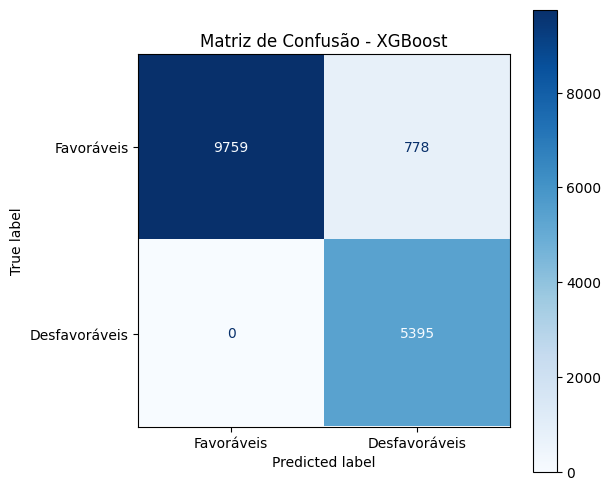

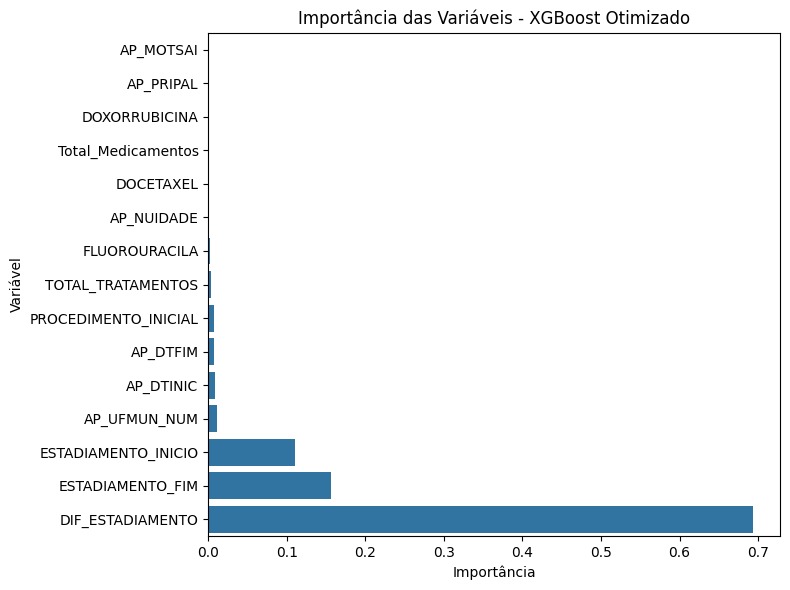

--------------------------------------------------

Verifique o arquivo 'emissions_xgboost.csv' no seu diretório para os dados de consumo e emissões.


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from codecarbon import EmissionsTracker  # Importando o CodeCarbon

# Carregando os dados
df_sem_alta = pd.read_pickle('../../dados_sem_alta_favoravel_desfavoravel.pickle')

# Pré-processamento básico
le_uf = LabelEncoder()
df_sem_alta['AP_UFMUN_NUM'] = le_uf.fit_transform(df_sem_alta['AP_UFMUN'])

label_cols = ['AP_PRIPAL']
for col in label_cols:
    le = LabelEncoder()
    df_sem_alta[col] = le.fit_transform(df_sem_alta[col].astype(str))

# Seleção de variáveis
variaveis_selecionadas = [
    'DIF_ESTADIAMENTO', 'ESTADIAMENTO_FIM', 'ESTADIAMENTO_INICIO',
    'AP_DTINIC', 'AP_DTFIM', 'PROCEDIMENTO_INICIAL', 'AP_UFMUN_NUM',
    'AP_MOTSAI', 'TOTAL_TRATAMENTOS', 'AP_PRIPAL',
    'DOXORRUBICINA', 'Total_Medicamentos',
    'DOCETAXEL', 'AP_NUIDADE', 'FLUOROURACILA'
]

X = df_sem_alta[variaveis_selecionadas]
y = df_sem_alta['VALOR_DESFECHO']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Definindo o peso de classes
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()

# Espaço de busca para otimização
param_dist = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
}

# Iniciando o monitoramento de emissões com o CodeCarbon
with EmissionsTracker(project_name="XGBoost Training", output_file="emissions_xgboost.csv") as tracker:
    # Instanciando o modelo base
    xgb_base = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        seed=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight_value
    )

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_dist,
        n_iter=20,
        scoring='recall',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    # Treinando modelo final com melhores parâmetros
    best_params = random_search.best_params_

    xgb_final = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight_value,
        **best_params
    )

    xgb_final.fit(X_train, y_train)

# Avaliação
y_pred = xgb_final.predict(X_test)
y_proba = xgb_final.predict_proba(X_test)[:, 1]

print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Favoráveis", "Desfavoráveis"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Matriz de Confusão - XGBoost")
plt.show()

# Importância das Variáveis
importancias = pd.Series(xgb_final.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(8, max(6, len(importancias) * 0.4)))
sns.barplot(x=importancias, y=importancias.index)
plt.title("Importância das Variáveis - XGBoost Otimizado")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

print("-" * 50)

# Para obter os resultados do CodeCarbon:
print("\nVerifique o arquivo 'emissions_xgboost.csv' no seu diretório para os dados de consumo e emissões.")
